<a href="https://colab.research.google.com/github/Jasmine-sizhe/utah-deep-learning/blob/main/softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs6353/assignments/assignment1/'
FOLDERNAME = 'cs6353/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Install requirements from colab_requirements.txt
# TODO: Please change your path below to the colab_requirements.txt file
! python -m pip install -r /content/drive/My\ Drive/$FOLDERNAME/colab_requirements.txt

Mounted at /content/drive
/content/drive/My Drive/cs6353/assignments/assignment1/cs6353/datasets
--2023-09-26 21:02:01--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  36.3MB/s    in 4.8s    

2023-09-26 21:02:06 (33.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/cs6353/assignments/assignment1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://utah.instructure.com/courses/919972/assignments/12590082) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
from __future__ import print_function
import random
import numpy as np
from cs6353.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs6353/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs6353/classifiers/softmax.py**.


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs6353/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs6353.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.371556
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** At initialization, all the weights are close to zero and the probabilities will be approximately equal. They would sum to 1 and each value will be 1/C for C classes. In this case, C=10, so we can expect our loss to be -log(0.1)


In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs6353.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.845759 analytic: -0.845759, relative error: 6.740911e-08
numerical: -1.844035 analytic: -1.844035, relative error: 1.932814e-08
numerical: -0.211643 analytic: -0.211643, relative error: 2.220848e-07
numerical: -1.325075 analytic: -1.325075, relative error: 2.385132e-08
numerical: -0.876904 analytic: -0.876904, relative error: 2.071513e-08
numerical: -0.456064 analytic: -0.456065, relative error: 2.526499e-08
numerical: -0.781719 analytic: -0.781718, relative error: 4.322009e-09
numerical: -1.158652 analytic: -1.158652, relative error: 4.118435e-09
numerical: -1.683932 analytic: -1.683932, relative error: 1.710352e-08
numerical: 0.344375 analytic: 0.344375, relative error: 2.946180e-08
numerical: -0.053879 analytic: -0.053879, relative error: 3.659014e-07
numerical: -1.508245 analytic: -1.508246, relative error: 1.865527e-08
numerical: -0.254773 analytic: -0.254774, relative error: 3.212899e-07
numerical: -0.667271 analytic: -0.667272, relative error: 6.804276e-08
numerica

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs6353.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.371556e+00 computed in 0.074661s
vectorized loss: 2.371556e+00 computed in 0.025214s
Loss difference: 0.000000
Gradient difference: 0.000000


In [11]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs6353.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 2e-6, 2.5e-6]
regularization_strengths = [1e3, 1e4, 2.5e4, 3e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifier in best_softmax.                          #
################################################################################

for lr in learning_rates:
  for reg in regularization_strengths:
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500)
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
      best_val = val_accuracy
      best_softmax = softmax

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr {} reg {} train accuracy: {} val accuracy: {}'.format(
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: {}'.format(best_val))

lr 1e-07 reg 1000.0 train accuracy: 0.2539183673469388 val accuracy: 0.234
lr 1e-07 reg 10000.0 train accuracy: 0.34938775510204084 val accuracy: 0.37
lr 1e-07 reg 25000.0 train accuracy: 0.32779591836734695 val accuracy: 0.338
lr 1e-07 reg 30000.0 train accuracy: 0.33002040816326533 val accuracy: 0.346
lr 1e-07 reg 50000.0 train accuracy: 0.31257142857142856 val accuracy: 0.323
lr 2e-06 reg 1000.0 train accuracy: 0.38616326530612244 val accuracy: 0.409
lr 2e-06 reg 10000.0 train accuracy: 0.332265306122449 val accuracy: 0.349
lr 2e-06 reg 25000.0 train accuracy: 0.2969591836734694 val accuracy: 0.316
lr 2e-06 reg 30000.0 train accuracy: 0.3010204081632653 val accuracy: 0.297
lr 2e-06 reg 50000.0 train accuracy: 0.282265306122449 val accuracy: 0.295
lr 2.5e-06 reg 1000.0 train accuracy: 0.38346938775510203 val accuracy: 0.389
lr 2.5e-06 reg 10000.0 train accuracy: 0.34130612244897957 val accuracy: 0.349
lr 2.5e-06 reg 25000.0 train accuracy: 0.28055102040816327 val accuracy: 0.289
lr 2

In [13]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.365000


**Inline Question** - *True or False*

It's possible to add a new data point to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: The SVM has margin, it is robust to a small change to the data. So if the case is that, the new datapoint falss into the safe side of the margin, then it won't change the loss function as well as the f. However, the Softmax does not have such margin, it is sensitive to the change of the dataset.

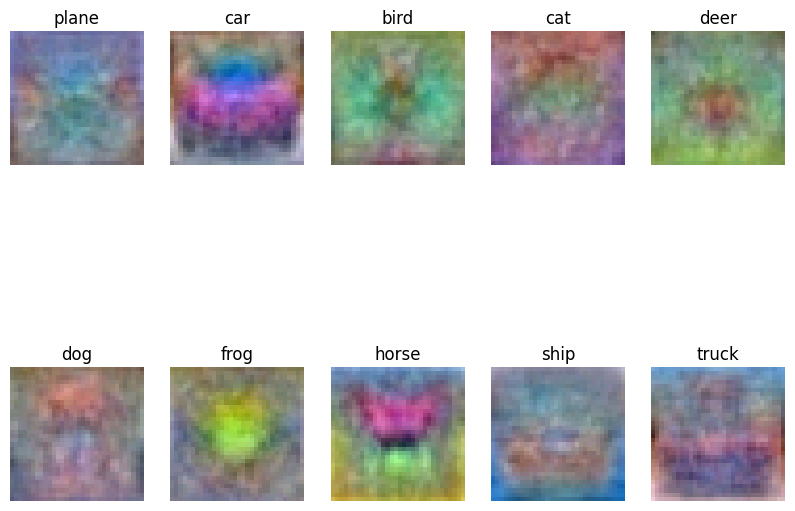

In [14]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])